# Entertainment
### Building Face detection model from the given set on images.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

## Loading the dataset

In [4]:
data = np.load('Dataset- Images.npy', allow_pickle=True)

In [5]:
data.shape

(409, 2)

#### Observations
1. The dataset is only 2-d while as for image dataset, it was expected to be 3-d. Hence we need the dataset values.

In [6]:
# Printing 1st value from the dataset
data[0]

array([array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8),
       list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 

#### Observations:
As we can see, the data at 0th index contains both the image as well as the label. Hence we need to extract the training images and the label into separate arrays to pass in the model.

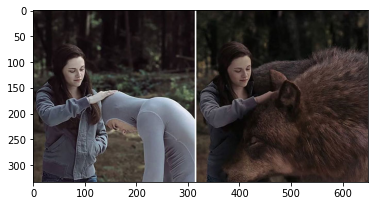

In [7]:
# Plotting the image present at 0th index 
plt.imshow(data[0][0])

In [8]:
# Label of the image present at 0th index
data[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

## Creating features and labels

For this, the image size will be considered as 256 and the pretrained model will be MobileNet

In [9]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [10]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

train_df = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:, :, :3]
    except:
        continue
    train_df[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [11]:
train_df.shape

(409, 224, 224, 3)

In [12]:
masks.shape

(409, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


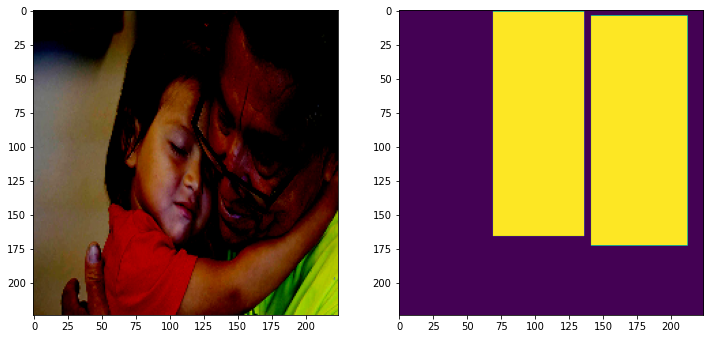

In [13]:
# Displaying random image with the mask
idx = np.random.randint(0, train_df.shape[0])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
ax1.imshow(train_df[idx])
ax2.imshow(masks[idx])
plt.show()

## Mask Detection Model

In [14]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("input_1").output         #224
    block2 = model.get_layer("conv_pw_1_relu").output  #112
    block3 = model.get_layer("conv_pw_3_relu").output  #56
    block4 = model.get_layer("conv_pw_5_relu").output  #28
    block5 = model.get_layer("conv_pw_11_relu").output #14
    block6 = model.get_layer("conv_pw_13_relu").output #7

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [15]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [16]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [17]:
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [18]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [19]:
checkpoint = ModelCheckpoint("model/model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min")
stop = EarlyStopping(monitor="loss", patience=10, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

model.fit(train_df, masks, epochs=20, batch_size=3, callbacks=[checkpoint, reduce_lr, stop], shuffle=True, verbose=1)

Epoch 1/20
137/137 [==============================] - 28s 174ms/step - loss: 1.8863 - dice_coefficient: 0.2598

Epoch 00001: loss improved from inf to 1.88628, saving model to model/model-1.89.h5
Epoch 2/20
137/137 [==============================] - 24s 172ms/step - loss: 1.2675 - dice_coefficient: 0.3980

Epoch 00002: loss improved from 1.88628 to 1.26754, saving model to model/model-1.27.h5
Epoch 3/20
137/137 [==============================] - 24s 172ms/step - loss: 1.0829 - dice_coefficient: 0.4581

Epoch 00003: loss improved from 1.26754 to 1.08295, saving model to model/model-1.08.h5
Epoch 4/20
137/137 [==============================] - 24s 172ms/step - loss: 0.9919 - dice_coefficient: 0.4976

Epoch 00004: loss improved from 1.08295 to 0.99195, saving model to model/model-0.99.h5
Epoch 5/20
137/137 [==============================] - 24s 172ms/step - loss: 0.9198 - dice_coefficient: 0.5208

Epoch 00005: loss improved from 0.99195 to 0.91983, saving model to model/model-0.92.h5
Epoc

#### Observations:
The best model is model-0.70.h5 which is having the minimum loss. Hence we will be using the same model for evaluation.

## Evaluate the model using testing data.

In [20]:
best_model = tf.keras.models.load_model('model/model-0.70.h5', custom_objects={'loss': loss, 'dice_coefficient': dice_coefficient})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


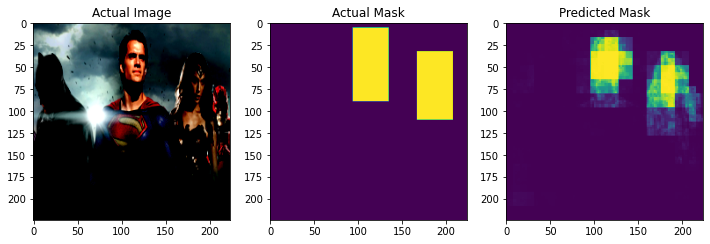

In [21]:
idx = np.random.randint(0, train_df.shape[0])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,8))

ax1.set_title('Actual Image')
ax1.imshow(train_df[idx])

ax2.set_title('Actual Mask')
ax2.imshow(masks[idx])

prediction = best_model.predict(train_df[idx].reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
ax3.set_title('Predicted Mask')
ax3.imshow(prediction.reshape(IMAGE_HEIGHT,IMAGE_WIDTH))

### Testing of the model on a image

In [22]:
pred_image = cv2.imread('Prediction_Image.jpeg')
test_image = cv2.resize(pred_image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
test_image = test_image[:, :, :3]
test_image = preprocess_input(test_image)

In [24]:
output = best_model.predict(test_image.reshape(1, 224, 224,3))

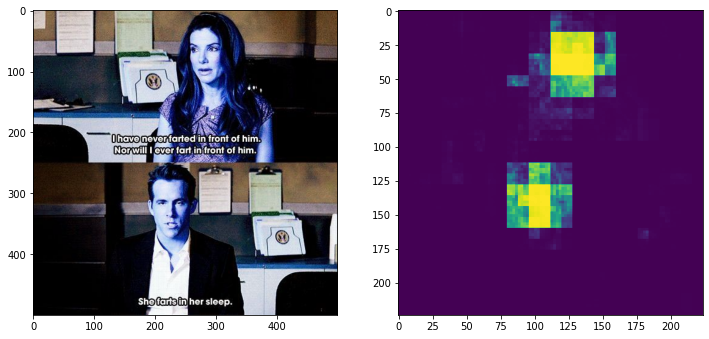

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))
ax1.imshow(pred_image)
ax2.imshow(output[0])
plt.show()

### Conclusion
We have built a UNET architecture based model for detecting faces. As we have seen in testing, the model is able to detect faces up to satisfaction but it can further improved to give better predictions.